In [102]:
!pip install langchain langgraph langsmith langchain_groq langchain_community

In [103]:
from typing import Annotated
from typing_extensions import TypedDict

In [104]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [105]:
!pip install arxiv

In [106]:
Arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=350)
Arxiv_tool=ArxivQueryRun(api_wrapper=Arxiv_wrapper)

In [107]:
!pip install wikipedia

In [108]:
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=350)
Wikipedia_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [109]:
Wikipedia_tool.invoke("who is ronaldo?")

'Page: Cristiano Ronaldo\nSummary: Cristiano Ronaldo dos Santos Aveiro (Portuguese pronunciation: [kɾiʃˈtjɐnu ʁɔˈnaldu] ; born 5 February 1985) is a Portuguese professional footballer who plays as a forward for and captains both Saudi Pro League club Al-Nassr and the Portugal national team. Nicknamed CR7, he is widely regarded as one of the greatest '

In [110]:
tools=[Wikipedia_tool,Arxiv_tool]

In [111]:
## Define LangGraph

In [112]:
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list,add_messages]

In [113]:
from langgraph.graph import START,END,StateGraph

In [114]:
graph_builder=StateGraph(State)

In [115]:
from langchain_groq import ChatGroq

In [116]:
from google.colab import userdata
groq_api_key=userdata.get('groq_api_key')

In [117]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

In [118]:
llm_with_tools=llm.bind_tools(tools=tools)

In [119]:
def chatbot(state:State):
  return {'messages':[llm_with_tools.invoke(state['messages'])]}

In [120]:
from langgraph.prebuilt import tools_condition,ToolNode

In [121]:
graph_builder.add_node('chatbot',chatbot)
graph_builder.add_edge(START,'chatbot')
tool_node=ToolNode(tools=tools)
graph_builder.add_node('tools',tool_node)



graph_builder.add_conditional_edges(
    'chatbot',tools_condition
)

graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge('chatbot',END)


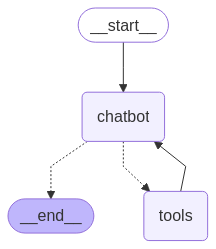

In [122]:
graph_builder.compile()

In [123]:
graph=graph_builder.compile()

In [125]:
user_input=" who is the president of india"
events=graph.stream(
    {'messages':[('user',user_input)]},stream_mode='values'
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

hi gemma how are you,and who is the president of india
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_m187)
 Call ID: call_m187
  Args:
    query: president of india
================================= Tool Message =================================
Name: wikipedia

Page: President of India
Summary: The president of India  (ISO: Bhārata kē Rāṣṭrapati) is the head of state of the Republic of India. The president is the nominal head of the executive, the first citizen of the country, and the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office on 25 
================================== Ai Message ==================================

The current president of India is Droupadi Murmu.
